In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn
import PIL
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [5]:
assert torch.__version__=='1.8.1'

In [6]:
import torchvision

In [11]:
torchvision.__version__

'0.2.2'

In [4]:
trainset = datasets.MNIST('digit_MNIST_data/', download = True, train = True, transform = transforms.ToTensor())
testset = datasets.MNIST('digit_MNIST_data/', download = True, train = False, transform = transforms.ToTensor())

0it [00:00, ?it/s]

Extracting digit_MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting digit_MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting digit_MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting digit_MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


/Users/Torgeir/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1616554845587/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Done!


In [129]:
trainset = torch.load('digit_MNIST_data/MNIST/processed/training.pt')#datasets.MNIST('digit_MNIST_data/', download = True, train = True, transform = transforms.ToTensor())
testset = torch.load('digit_MNIST_data/MNIST/processed/test.pt')#datasets.MNIST('digit_MNIST_data/', download = True, train = False, transform = transforms.ToTensor())
trainset = torch.unsqueeze(trainset[0]/255,dim=1)
testset = torch.unsqueeze(testset[0]/255,dim=1)

In [48]:
def blur(img,blur_size):
    blur = nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size=blur_size[0],bias=False, padding=blur_size[0]//2,stride=1)
    blur.weight = nn.Parameter(torch.ones((1,1,blur_size[0],blur_size[1]))/(blur_size[0]*blur_size[1]),requires_grad=False)
    return blur.forward(img)

In [38]:
#torch.unsqueeze(trainset_blur[0][:10,:],dim=1).shape

In [39]:
#trainset_blur = torch.unsqueeze(trainset_blur[0]/255,dim=1)

In [130]:
blurred_trainset = blur(trainset, (5,5))

In [131]:
blurred_testset = blur(testset, (5,5))

In [16]:
trainset_blur[:10].shape

torch.Size([10, 1, 28, 28])

In [132]:
blurred_trainset.shape

torch.Size([60000, 1, 28, 28])

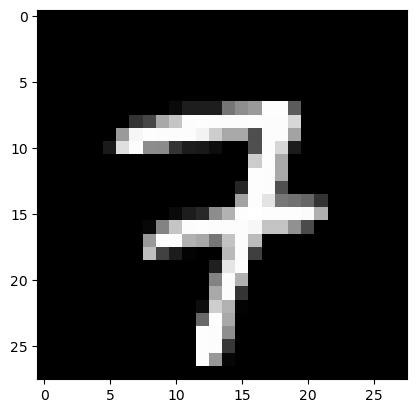

In [50]:
#plt.imshow(ddnd[0,0], cmap='gray')
plt.imshow(trainset[898,0], cmap='gray')

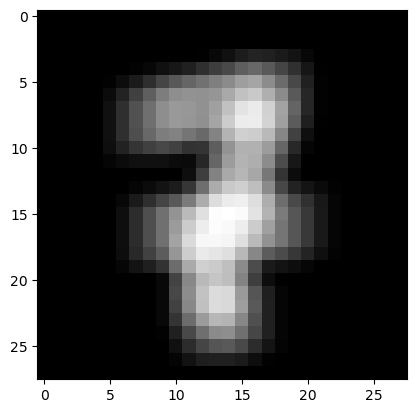

In [134]:
plt.imshow(blurred_testset[898,0], cmap='gray')

In [45]:
#blurrer = transforms.GaussianBlur(kernel_size=5, sigma=0.1)
#blur = blurrer(trainset_blur)

In [135]:
np.random.seed(0)
torch.manual_seed(0)

In [136]:
class FashionNeihgborhoodData(Dataset):

    def __init__(self, image_dir, blurred_dataset, transform=False, nbh_size=(5,11), blur_size=(5,5)):#csv_file,root,
        #self.root = root
        self.image_dir = image_dir
        #self.image_files = os.listdir(image_dir)
        #self.data = pd.read_csv(csv_file).iloc[:, 1]
        self.fashion_data = torch.load(image_dir)
        self.fashion_imgs = self.fashion_data[0]/255
        self.fashion_labels = self.fashion_data[1]
        self.transform = transform
        self.nbh_size = nbh_size
        self.blurred_dataset = torch.squeeze(blurred_dataset,dim=1)
        self.blur_size = blur_size

    def __len__(self):
        return self.fashion_labels.shape[0]

    def __getitem__(self, index):
        #image_name = os.path.join(self.image_dir, self.image_files[index])  
        #image = PIL.Image.open(image_name)
        image = self.fashion_imgs[index]
        blr_image = self.blurred_dataset[index]
        #label = self.data[index]
        if self.transform:
            image = self.transform(image)

        h, w = self.blur_size[0]//2, self.blur_size[1]//2
        
        nbh_im = torch.empty((0,50+self.blur_size[0]*self.blur_size[1]))
        #blur_nbh_im = torch.empty((0,self.blur_size[0*self.blur_size[1]]))
        for i in range(20):
            #x1 = np.random.randint(0, images[1].shape[1]-self.nbh_size[0]-1)
            #y1 = np.random.randint(0, images[1].shape[2]-self.nbh_size[1]-1)
            x1 = np.random.randint(0, image.shape[0]-self.nbh_size[0]-1)
            y1 = np.random.randint(0, image.shape[1]-self.nbh_size[1]-1)
            
            x2, y2 = x1+self.nbh_size[0], y1+self.nbh_size[1]
            nbh = torch.flatten(image[x1:x2,y1:y2])
            blur_nbh = torch.flatten(blr_image[x1+self.blur_size[0]-h-1:x1+self.blur_size[0]+h,y1+self.blur_size[1]-w-1:y1+self.blur_size[1]+w])
            nbh = nbh[:50]
            blur_nbh_and_nbh = torch.cat((blur_nbh,nbh),dim=0)
            nbh_im = torch.cat((nbh_im, blur_nbh_and_nbh.unsqueeze(0)), dim = 0)
        
        return nbh_im#image #, label)

In [92]:
#x1 = np.random.randint(0, 28-5-1)
#y1 = np.random.randint(0, 28-11-1)
            
#x2, y2 = x1+5, y1+11
#nbh = trainset[9,0,x1:x2,y1:y2]
#nnn = torch.flatten(nbh)

In [91]:
#bbbb = trainset[9,0,x1+5-2-1:x1+5+2,y1+5-2-1:y1+5+2]
#plt.imshow(trainset[9,0,x1+5-2-1:x1+5+2,y1+5-2-1:y1+5+2])
#bbb = torch.flatten(bbbb)
#torch.cat((bbb,nnn),dim=0).shape

In [93]:
#plt.imshow(trainset[9,0])

In [94]:
#torch.ones((1,50)).shape

In [137]:
class MLP_Mix(nn.Module):#define neighborhood size
    '''
    Multilayer Perceptron.
    '''
    def __init__(self, first_layer_size, num_mixtures):
        super().__init__()
        self.first_layer_size = first_layer_size
        self.num_mixtures = num_mixtures
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.first_layer_size, 150),
        nn.ReLU(),
        #nn.LeakyReLU(),
        nn.Linear(150, 150),
        nn.ReLU(),
        #nn.LeakyReLU(),
        nn.Linear(150, 150),
        nn.ReLU(), ## leaky relu
        #nn.LeakyReLU(),
        nn.Linear(150, 150),
        nn.ReLU(), ## leaky relu
        nn.Linear(150, 3*self.num_mixtures),#,
        #nn.ReLU()
        #nn.Sigmoid()
        
        )
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        '''Forward pass'''
        out = self.layers(x)

        softplus = nn.Softplus()
        sigmoid = nn.Sigmoid()

        mu = torch.reshape(out[:,0:self.num_mixtures],(out.shape[0],self.num_mixtures))
        mu1 = torch.reshape(mu[:,0],  (out.shape[0], 1))
        mu2 = mu1 + torch.reshape(softplus(mu[:,1]), (out.shape[0], 1))
        mu = torch.cat((mu1,mu2), dim=1)
        mu = sigmoid(mu) #- 0.5

        sig = torch.reshape(softplus(out[:,1*self.num_mixtures:2*self.num_mixtures]),(out.shape[0],self.num_mixtures)) #sig squared
        sig = torch.clamp(sig, 0.00000001)

        pi_mix = torch.reshape(out[:,2*self.num_mixtures:3*self.num_mixtures],(out.shape[0],self.num_mixtures))
        pi_mix = self.softmax(pi_mix)

        out = torch.cat((mu,sig,pi_mix),dim=1)

        return out

In [138]:
def Mixture_Gauss_NLLLoss(target, pred):# mu, sigma, pi_mix):
    total_lik = 0
    loss_func  = nn.GaussianNLLLoss(full=False, reduction='none')

    nr_mix = int(pred.shape[1]/3)

    mu = pred[:,0:nr_mix]
    sigma_sq = pred[:,nr_mix:2*nr_mix]  #sigma2 
    pi_mix = pred[:,2*nr_mix:3*nr_mix]  

    sigma_sq = torch.clamp(sigma_sq, 0.00000001)
    for i in range(nr_mix):

        loss = loss_func(mu[:,i], target, sigma_sq[:,i])
        likelihood = torch.exp(-loss)
        
        total_lik += pi_mix[:,i]*likelihood

    
    gauss_mix_loss = torch.log(torch.clamp(total_lik, min=0.00000001))
   
    return -gauss_mix_loss.mean()  #torchmean

In [139]:
MNIST_train = FashionNeihgborhoodData(image_dir='digit_MNIST_data/MNIST/processed/training.pt',blurred_dataset=blurred_trainset)
MNIST_test = FashionNeihgborhoodData(image_dir='digit_MNIST_data/MNIST/processed/test.pt', blurred_dataset=blurred_testset)

In [180]:
mlp_mix = MLP_Mix(first_layer_size=49+25, num_mixtures=2)

# Define the loss function and optimizer
loss_function  = Mixture_Gauss_NLLLoss

#optimizer = torch.optim.SGD(mlp_mix.parameters(), lr=0.001)
#lr_scheduler = 
optimizer = torch.optim.Adam(mlp_mix.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [10]:
#sum(p.numel() for p in mlp_mix.parameters() if p.requires_grad)

35906

In [181]:
dataloader_train = DataLoader(MNIST_train, batch_size=20,
                        shuffle=True)#, num_workers=0)

dataloader_test = DataLoader(MNIST_test, batch_size=20,
                        shuffle=True)

In [182]:
epochs = 50 #20
loss_vals_train = []
loss_vals_test = []

In [183]:
for e in range(epochs): 
    
    print(f'Starting epoch {e+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    for i, data in enumerate(dataloader_train, 0):
        
        #current_loss = 0.0
      # Get and prepare inputs
        data = torch.reshape(data,(-1,50+25))
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = mlp_mix(inputs)
        
      # Compute loss
        
        loss = loss_function(targets, outputs)#mu_s, sigma_s, pi_mix)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        current_loss += loss.item()
        
        #if i % 500 == 0:
        #if i % 20 == 0:
    scheduler.step()

    print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / len(dataloader_train)))
    #current_loss = 0.0

    validation_loss = 0.0
    mlp_mix.eval()

    for i, data in enumerate(dataloader_test, 0):

        data = torch.reshape(data,(-1,50+25))
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        outputs = mlp_mix(inputs)

        loss_val = loss_function(targets, outputs)# mu_s, sigma_s, pi_mix)

        validation_loss += loss_val.item()


    print('Val Loss after mini-batch %5d: %.3f' %
                (i + 1, validation_loss / len(dataloader_test)))
  # Process is complete.
    loss_vals_train.append(current_loss/len(dataloader_train))
    loss_vals_test.append(validation_loss/len(dataloader_test))

print('Training process has finished.')

Starting epoch 1
Loss after mini-batch  3000: -4.505
Val Loss after mini-batch   500: -4.990
Starting epoch 2
Loss after mini-batch  3000: -5.042
Val Loss after mini-batch   500: -5.090
Starting epoch 3
Loss after mini-batch  3000: -5.135
Val Loss after mini-batch   500: -5.184
Starting epoch 4
Loss after mini-batch  3000: -5.215
Val Loss after mini-batch   500: -5.246
Starting epoch 5
Loss after mini-batch  3000: -5.270
Val Loss after mini-batch   500: -5.288
Starting epoch 6
Loss after mini-batch  3000: -5.297
Val Loss after mini-batch   500: -5.316
Starting epoch 7
Loss after mini-batch  3000: -5.327
Val Loss after mini-batch   500: -5.307
Starting epoch 8
Loss after mini-batch  3000: -5.348
Val Loss after mini-batch   500: -5.356
Starting epoch 9
Loss after mini-batch  3000: -5.366
Val Loss after mini-batch   500: -5.373
Starting epoch 10
Loss after mini-batch  3000: -5.389
Val Loss after mini-batch   500: -5.398
Starting epoch 11
Loss after mini-batch  3000: -5.404
Val Loss after 

In [184]:
torch.save(mlp_mix.state_dict(), 'FCNN_blur_mnist_model.pt')

Text(0.5, 1.0, 'loss')

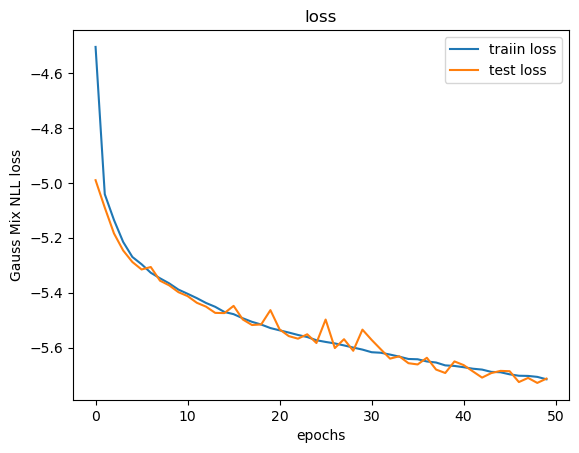

In [185]:
plt.plot(range(len(loss_vals_train)),loss_vals_train, label='traiin loss')
plt.plot(range(len(loss_vals_test)),loss_vals_test, label='test loss')
plt.xlabel('epochs')
plt.ylabel('Gauss Mix NLL loss')
plt.legend()
plt.savefig('../figures_blur/MNIST_FCNN_blur_loss_plot.jpg')
plt.title('loss')

In [186]:
def gen_im_mix(model, new_img, nbh_size, blur_size):#im_size, nbh_size):
    m, n = nbh_size
    
    im_size = new_img.shape
    #new_im = torch.rand(im_size)-0.5 # prøv med 0.5
    #new_im = torch.full(im_size,0.5)
    new_im = new_img.clone()
    pred_mu = np.zeros(im_size)
    pred_sigma2 = np.zeros(im_size)
    pred_mu2 = np.zeros(im_size)
    pred_sigma2_2 = np.zeros(im_size)
    pred_pi_mix = np.zeros(im_size)
    bl_im = new_img.clone()
    h, w = blur_size
    h = h//2
    w = w//2

    #new_im = fashion_imgs_test[0][2]/255 - 0.5
    #new_im = new_im.numpy()
    
    for i in range(m, new_im.shape[0]-h):
        for j in range(n, new_im.shape[1]-n):
            
            neighborhood = new_im[i+1-m:i+1,j-n:(j+n+1)]
            flat_n = neighborhood.flatten()
            blur_nbh = bl_im[i-h:i+h+1, j-w:j+w+1]
            blur_nbh_flat = blur_nbh.flatten()
            dlt = n
            
            nbh_ij = flat_n[:-(dlt+1)]

            nbh_and_blur = torch.cat((blur_nbh_flat,nbh_ij),dim=0)
            
            output = model(torch.reshape(nbh_and_blur,(1,49+25))).detach().numpy()

            #pi_mix_output = output[0,2]
            #mu_output = output[0,0]
            #sigma2_output = output[0,1]
            #print(sigma2_output)
            nr_mix = int(output.shape[1]/3)

            pi_mix_output = output[0,2*nr_mix:]
            mu_output = output[0,0:nr_mix]
            sigma2_output = output[0,nr_mix:2*nr_mix]
            #print(pi_mix_output)
            
            pi_mix_sample = np.random.choice(nr_mix, 1, p=pi_mix_output)[0]
            #pi_mix_sample = 0
            
            #sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            sample = np.random.normal(mu_output[pi_mix_sample], np.sqrt(sigma2_output[pi_mix_sample]))
            #sample = np.random.normal(mu_output, np.sqrt(sigma2_output))
            
            sample = np.clip(sample, 0.0, 1.0)
            new_im[i,j] = sample

            #new_im[i,j] = torch.from_numpy(mu_output)[pi_mix_sample]

            #pred_mu[i,j] = mu_output[pi_mix_sample]
            #pred_sigma2[i,j] = sigma2_output[pi_mix_sample]
            pred_mu[i,j] = mu_output[0]
            pred_sigma2[i,j] = sigma2_output[0]

            pred_mu2[i,j] = mu_output[1]
            pred_sigma2_2[i,j] = sigma2_output[1]
            pred_pi_mix[i,j] = pi_mix_output[0]
    
    #return new_im, pred_mu, pred_sigma2
    return new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix

In [147]:
mnist_imgs_train = torch.load('digit_MNIST_data/MNIST/processed/training.pt')
mnist_imgs_test = torch.load('digit_MNIST_data/MNIST/processed/test.pt')

In [10]:
mlp_mix = MLP_Mix(first_layer_size=49, num_mixtures=2)
mlp_mix.load_state_dict(torch.load('FCNN_mnist_model.pt'))
mlp_mix.eval()

MLP_Mix(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=49, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=6, bias=True)
  )
  (softmax): Softmax(dim=1)
)

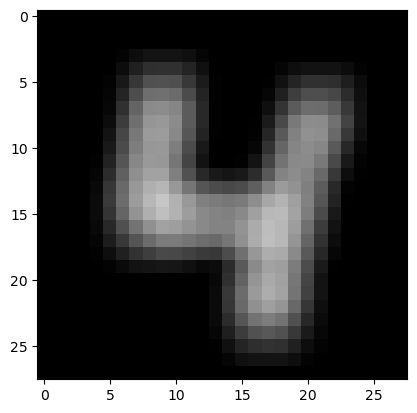

In [169]:
plt.imshow(blurred_testset[56,0], vmin=0, vmax=1,cmap='gray')

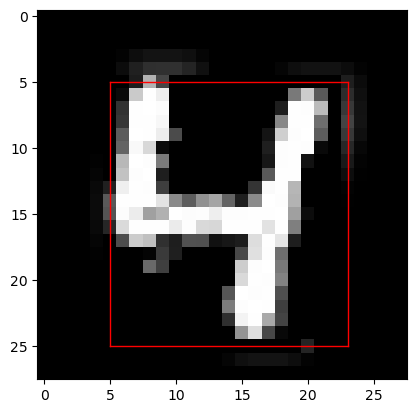

In [187]:
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix(mlp_mix, blurred_testset[56,0], (5,5), (5,5))
plt.imshow(new_im, vmin=0, vmax=1,cmap='gray')
x = [5, 23]
y = [5, 5]
xx = [5, 5]
yy = [5, 25]
xxx = [23, 23]
yyy = [5, 25]
xxxx = [5, 23]
yyyy = [25, 25]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.plot(xxxx, yyyy, color="red", linewidth=1)

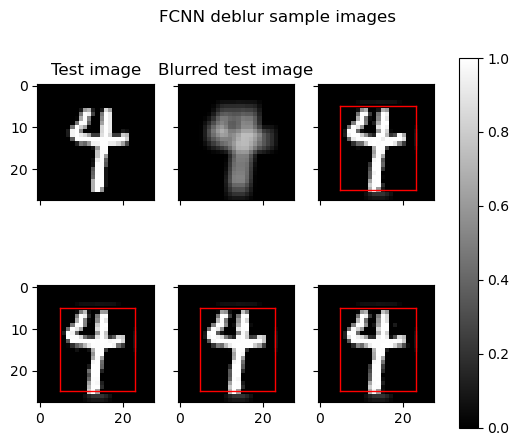

In [200]:
fig, axes = plt.subplots(nrows=2, ncols=3,sharex=True, sharey=True)
x = [5, 23]
y = [5, 5]
xx = [5, 5]
yy = [5, 25]
xxx = [23, 23]
yyy = [5, 25]
xxxx = [5, 23]
yyyy = [25, 25]
for i, ax in enumerate(axes.flat):
    if i==0:
        im = ax.imshow( mnist_imgs_test[0][565]/255, vmin=0, vmax=1,cmap='gray')

    elif i==1:
        im = ax.imshow(blurred_testset[565,0], vmin=0, vmax=1,cmap='gray')

    else:
        new_im, _, _, _, _, _ = gen_im_mix(mlp_mix, blurred_testset[565,0], (5,5), (5,5))
        im = ax.imshow(new_im, vmin=0, vmax=1,cmap='gray')
        ax.plot(x, y, color="red", linewidth=1)
        ax.plot(xx, yy, color="red", linewidth=1)
        ax.plot(xxx, yyy, color="red", linewidth=1)
        ax.plot(xxxx, yyyy, color="red", linewidth=1)

axes[0,0].set_title("Test image")
axes[0,1].set_title("Blurred test image")
image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('FCNN deblur sample images')
plt.savefig('../figures_blur/MNIST_FCNN_blur_sample1.jpg')
plt.show()

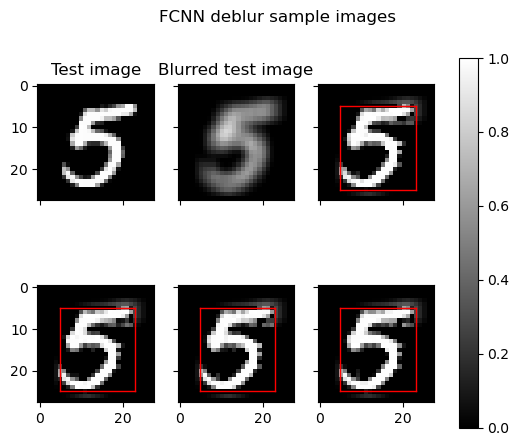

In [199]:
fig, axes = plt.subplots(nrows=2, ncols=3,sharex=True, sharey=True)
x = [5, 23]
y = [5, 5]
xx = [5, 5]
yy = [5, 25]
xxx = [23, 23]
yyy = [5, 25]
xxxx = [5, 23]
yyyy = [25, 25]
for i, ax in enumerate(axes.flat):
    if i==0:
        im = ax.imshow( mnist_imgs_test[0][356]/255, vmin=0, vmax=1,cmap='gray')

    elif i==1:
        im = ax.imshow(blurred_testset[356,0], vmin=0, vmax=1,cmap='gray')

    else:
        new_im, _, _, _, _, _ = gen_im_mix(mlp_mix, blurred_testset[356,0], (5,5), (5,5))
        im = ax.imshow(new_im, vmin=0, vmax=1,cmap='gray')
        ax.plot(x, y, color="red", linewidth=1)
        ax.plot(xx, yy, color="red", linewidth=1)
        ax.plot(xxx, yyy, color="red", linewidth=1)
        ax.plot(xxxx, yyyy, color="red", linewidth=1)

axes[0,0].set_title("Test image")
axes[0,1].set_title("Blurred test image")
image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('FCNN deblur sample images')
plt.savefig('../figures_blur/MNIST_FCNN_blur_sample2.jpg')
plt.show()

In [46]:
mnist_imgs_test[0][17].shape

torch.Size([28, 28])

In [52]:
#new_im, _, _, _, _, _ = gen_im_mix(mlp_mix, torch.zeros((100,100)), (5,5))
#plt.imshow(new_im,cmap='gray')
"""
x = [5, 23]
y = [10, 10]
xx = [5, 5]
yy = [10, 27]
xxx = [23, 23]
yyy = [10, 27]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
"""
#plt.savefig('../figures/MNIST_FCNN_sample1.jpg')
#plt.title('FCNN sample with 2')
#plt.colorbar()

'\nx = [5, 23]\ny = [10, 10]\nxx = [5, 5]\nyy = [10, 27]\nxxx = [23, 23]\nyyy = [10, 27]\nplt.plot(x, y, color="red", linewidth=1)\nplt.plot(xx, yy, color="red", linewidth=1)\nplt.plot(xxx, yyy, color="red", linewidth=1)\n'

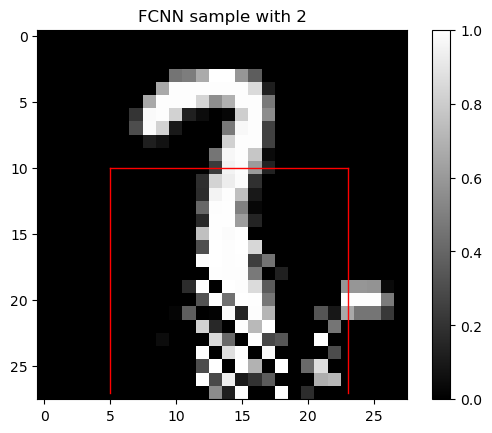

In [134]:
plt.imshow(new_im,cmap='gray')
x = [5, 23]
y = [10, 10]
xx = [5, 5]
yy = [10, 27]
xxx = [23, 23]
yyy = [10, 27]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
#plt.savefig('../figures/MNIST_FCNN_sample1.jpg')
plt.title('FCNN sample with 2')
plt.colorbar()

In [116]:
#plt.imshow(mnist_imgs_test[0][1]/255,cmap='gray')

In [57]:
#no sampling
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix(mlp_mix, mnist_imgs_test[0][1]/255, (5,5))

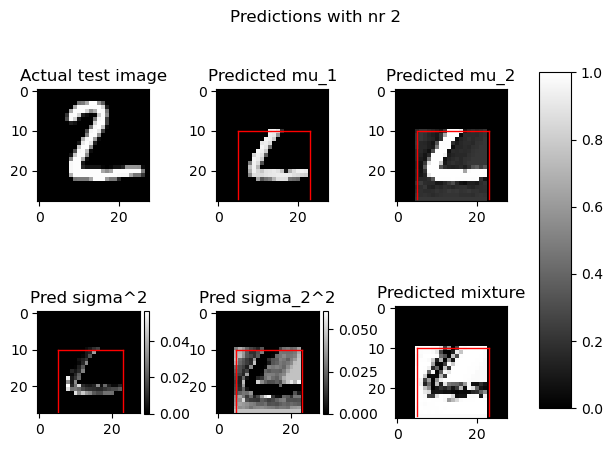

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=3)#,sharex=True, sharey=True)

im = axes.flat[0].imshow(new_im, vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image")

x = [5, 23]
y = [10, 10]
xx = [5, 5]
yy = [10, 27]
xxx = [23, 23]
yyy = [10, 27]

axes[0,1].plot(x, y, color="red", linewidth=1)
axes[0,1].plot(xx, yy, color="red", linewidth=1)
axes[0,1].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[1].imshow(pred_mu, vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Predicted mu_1")

axes[0,2].plot(x, y, color="red", linewidth=1)
axes[0,2].plot(xx, yy, color="red", linewidth=1)
axes[0,2].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[2].imshow(pred_mu2, vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
axes[0,2].set_title("Predicted mu_2")

axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[3].imshow(pred_sigma2,cmap='gray')
#plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
fig.colorbar(im,ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("Pred sigma^2")

axes[1,1].plot(x, y, color="red", linewidth=1)
axes[1,1].plot(xx, yy, color="red", linewidth=1)
axes[1,1].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[4].imshow(pred_sigma2_2, cmap='gray')
fig.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
#plt.colorbar(im, ax=axes[1,1])#,fraction=0.046, pad=0.04)
axes[1,1].set_title("Pred sigma_2^2")

axes[1,2].plot(x, y, color="red", linewidth=1)
axes[1,2].plot(xx, yy, color="red", linewidth=1)
axes[1,2].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[5].imshow(pred_pi_mix, vmin=0, vmax=1,cmap='gray')
axes[1,2].set_title("Predicted mixture")


fig.suptitle('Predictions with nr 2')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
fig.tight_layout()
#fig.set_figheight(5)
#fig.set_figwidth(10)
#fig.colorbar(im, ax=axes[[0,1],2],fraction=0.46)#, pad=0.04)#fraction=0.46, pad=0.4)# ax=axes.ravel().tolist())
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('../figures/MNIST_FCNN_pred_res1.jpg')
plt.show()

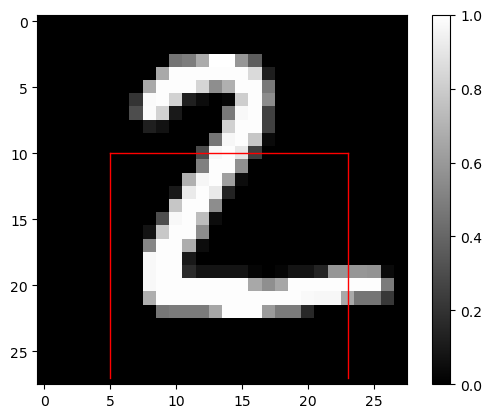

In [137]:
plt.imshow(new_im,cmap='gray')
x = [5, 23]
y = [10, 10]
xx = [5, 5]
yy = [10, 27]
xxx = [23, 23]
yyy = [10, 27]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
#plt.savefig('../figures/MNIST_FCNN_sample3.jpg')
plt.colorbar()

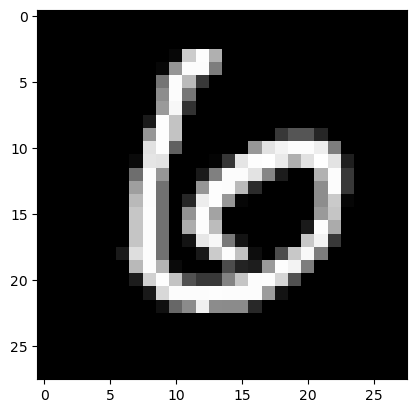

In [202]:
plt.imshow(mnist_imgs_test[0][11]/255,cmap='gray')

In [38]:
mnist_imgs_train = torch.load('digit_MNIST_data/MNIST/processed/training.pt')
mnist_imgs_test = torch.load('digit_MNIST_data/MNIST/processed/test.pt')

In [39]:
#mnist_imgs_train[0][2].shape

torch.Size([28, 28])

In [44]:
#plt.imshow(mnist_imgs_train[0][2]/255,cmap='gray')
#plt.colorbar()

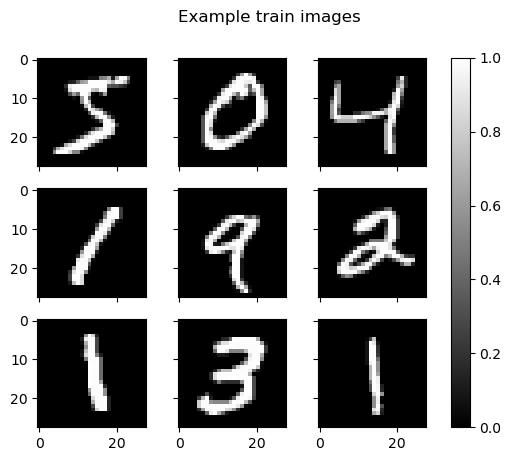

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=3,sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    im = ax.imshow(mnist_imgs_train[0][i]/255, vmin=0, vmax=1,cmap='gray')

image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('Example train images')
plt.savefig('../figures/MNIST_train_im.jpg')#, image)
plt.show()